In [1]:
# Load libraries
import tensorflow as tf
import cv2 # install opencv-python
import random
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Basic Functions:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d( x, W,strides=[1,1,1,1],padding='SAME' )


def max_pool_2x2(x,name):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x,ksize=[1,2,2,1],
                          strides=[1,2,2,1],name=name,padding="SAME")
 

def weight_variable(shape,varname):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=varname)


def bias_variable(shape,varname):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=varname)

In [3]:
# Build ConvNet
def deepnn(x):
    # x is 240x240x3
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5,5,3,16],'conv_w')
        b_conv1 = bias_variable([16],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x,W_conv1)+b_conv1)
        h_pool1 = max_pool_2x2(h_conv1,'mp')
    # output: 120x120x16
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5,5,16,16],'conv_w')
        b_conv2 = bias_variable([16],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2)+b_conv2)
        h_pool2 = max_pool_2x2(h_conv2,'mp')
    # output: 60x60x16

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5,5,16,32],'conv_w')
        b_conv3 = bias_variable([32],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2,W_conv3)+b_conv3)
        h_pool3 = max_pool_2x2(h_conv3,'mp')
    # output: 30x30x32

    with tf.name_scope('conv4'):
        W_conv4 = weight_variable([5,5,32,32],'conv_w')
        b_conv4 = bias_variable([32],'conv_b')
        h_conv4 = tf.nn.relu(conv2d(h_pool3,W_conv4)+b_conv4)
        h_pool4 = max_pool_2x2(h_conv4,'mp')
    # output: 15x15x32

    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool4_flat = tf.reshape(h_pool4,[-1,15*15*32])
        # Fully connected + Relu
        # input: flat (15x15x32) = 1x7200
        W_fc1 = weight_variable([15*15*32,3600],'fc_w')
        b_fc1 = bias_variable([3600],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat,W_fc1)+b_fc1)
    # output: 1x3600
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 115200 features to 8 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([3600,8],'sm_w')
        b_sm = bias_variable([8],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop,W_sm),b_sm,name="y_conv_op")
 
    return y_conv_out,keep_prob

In [4]:
# Extra functions:
# DataSet class to handle images 
class DataSet(object):
    def __init__(self, images, labels):
        self._num_examples = len(images)
        self._images = images
        self._labels = labels
        self._epochs_done = 0
        self._index_in_epoch = 0
        np.random.seed(123456)
        # Shuffle the data
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        random.seed(123456)
    @property
    def images(self):
        return self._images
    @property
    def labels(self):
        return self._labels
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_done(self):
        return self._epochs_done
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm] 
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
    
        return self._images[start:end], self._labels[start:end]

# read images from a directory
def read_images(path,images,labels,class_num,class_index):
    files = glob.glob(os.path.join(path, '*')) # delete the 'g' if you are getting an error while loading images
    for fl in files:
        image = cv2.imread(fl)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        label = np.zeros(class_num)
        label[class_index] = 1.0
        labels.append(label)
    return images,labels

def read_mona(image):
    image = cv2.imread(image)
    image = image.astype(np.float32)
    image = np.multiply(image, 1.0 / 255.0)
    return image

In [7]:
#Elaine
#mypath = '/home/yingjie/Desktop/Machine_Learning/Assignment5/'
#mona_path = '/home/yingjie/Desktop/Machine_Learning/Facial-expression-detection/images/'
#Jo
mypath='/Users/Pan/Google Drive/Data Science/Machine Learning/Facial-expression-detection/images/'
mona_path=mypath

#Common
train_path=mypath+'train/'
testing_path=mypath+'valid/'

Reading images
Finished reading images


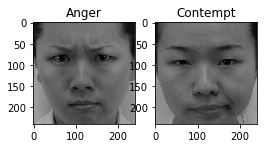

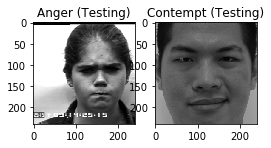

In [6]:
# load images
images = []
labels = []
testing_images = []
testing_labels = []

emotions = ['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise']

print('Reading images')
images,labels=read_images(train_path +'anger',images,labels,8,0)
images,labels=read_images(train_path +'contempt',images,labels,8,1)
images,labels=read_images(train_path +'disgust',images,labels,8,2)
images,labels=read_images(train_path +'fear',images,labels,8,3)
images,labels=read_images(train_path +'happiness',images,labels,8,4)
images,labels=read_images(train_path +'neutral',images,labels,8,5)
images,labels=read_images(train_path +'sadness',images,labels,8,6)
images,labels=read_images(train_path +'surprise',images,labels,8,7)

testing_images,testing_labels=read_images(testing_path +'anger',testing_images,testing_labels,8,0)
testing_images,testing_labels=read_images(testing_path +'contempt',testing_images,testing_labels,8,1)
testing_images,testing_labels=read_images(testing_path +'disgust',testing_images,testing_labels,8,2)
testing_images,testing_labels=read_images(testing_path +'fear',testing_images,testing_labels,8,3)
testing_images,testing_labels=read_images(testing_path +'happiness',testing_images,testing_labels,8,4)
testing_images,testing_labels=read_images(testing_path +'neutral',testing_images,testing_labels,8,5)
testing_images,testing_labels=read_images(testing_path +'sadness',testing_images,testing_labels,8,6)
testing_images,testing_labels=read_images(testing_path +'surprise',testing_images,testing_labels,8,7)

print('Finished reading images') 

images = np.array(images)
labels = np.array(labels)
testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)

# Create dataset
train = DataSet(images, labels)
test = DataSet(testing_images, testing_labels)

# parameters
model_dir="model_emotions"
max_itr=1
image_size=240

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(images[0])
ax.set_title('Anger')  

ax = fig.add_subplot(122)
plt.imshow(images[136])
ax.set_title('Contempt')

plt.show()

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(testing_images[0])
ax.set_title('Anger (Testing)')  

ax = fig.add_subplot(122)
plt.imshow(testing_images[17])
ax.set_title('Contempt (Testing)')

plt.show()

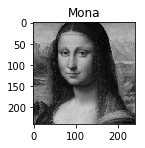

In [8]:
from PIL import Image

mona = Image.open(mona_path +'MonaList.jpg')
mona = mona.save(mona_path +'Mona.png')

mona = read_mona(mona_path+'Mona.png')
mona = np.array(mona)


# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(mona)
ax.set_title('Mona')  

plt.show()

In [9]:
# ******** Cell - 1 ***********
graph = tf.Graph()
with graph.as_default():   
    # Create the computational graph:
    # Placeholders:
    x = tf.placeholder(tf.float32,[None,image_size,image_size,3],name="x")
    y = tf.placeholder(tf.float32,[None,8],name="y")
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        
    # Build the graph for the deep net
    y_conv_out,keep_prob = deepnn(x)
    print(y_conv_out.shape)
    print(y.shape)
    
    # Add loss, accuracy and optimization
    probs=tf.nn.softmax(logits=y_conv_out, name="probs_op")
    
    
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_conv_out)
        cross_entropy = tf.reduce_mean(cross_entropy)
    
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv_out, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction, name="acc_op")
        
    # Add a saver to save the trained model
    saver = tf.train.Saver()

(?, 8)
(?, 8)


AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'softmax_cross_entropy_with_logits_v2'

In [ ]:
import random
rand=random.sample(range(1, 100), 77)
train = DataSet(images[rand], labels[rand])

In [ ]:
# ******** Cell - 2 ***********
# Reset graph: useful for multiple runs (e.g., parameter tuning, CV, etc.)
tf.reset_default_graph()  
# Create session to execute graph
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_itr):
        # Save a version of the model every 100 iterations
        if i>0 and i%100==0:
            saver.save(sess, "./%s/model"%(model_dir), global_step=i)
            
        # Get a batch of 32 images    
        x_batch, y_true_batch = train.next_batch(1)
        #print((x_batch).shape)
        #print((y_true_batch).shape)
           
        # Get training accuracy on the batch
        if i>0 and i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:x_batch
                                                      ,y:y_true_batch,keep_prob:1})
            print('step %d, training accuracy %g' % (i, train_accuracy))
           
            
        # Train
        train_step.run(feed_dict={x:x_batch,y:y_true_batch,keep_prob:0.5})

    # save final model
    save_path = saver.save(sess, "./%s/model"%(model_dir), global_step=max_itr)
    print("Model saved in file: %s" % save_path)
    
    # Get training accuracy on all training images
    train_accuracy=accuracy.eval(feed_dict={x:images[rand],y:labels[rand],keep_prob:1})
    print ("Training Accuracy: %10.5f"%train_accuracy)
    
    # Get testing accuracy on all training images
    test_accuracy=accuracy.eval(feed_dict={x:testing_images[rand],y:testing_labels[rand],keep_prob:1})
    print ("Testing Accuracy: %10.5f"%test_accuracy)

In [ ]:
mona = np.reshape(mona,[1,image_size,image_size,3])

In [ ]:

def load_and_predict(test,modelDir,itr):
    with tf.Session() as sess:
        print ("Load model:%s"%(modelDir))
        saver = tf.train.import_meta_graph("%s/model-%s.meta"%(modelDir,itr))
        saver.restore(sess,tf.train.latest_checkpoint("%s"%modelDir))
        graph2 = tf.get_default_graph()
    
        x = graph2.get_tensor_by_name("x:0")
        x_batch = test
        
        y_true_batch = graph2.get_tensor_by_name("y:0") 
        y_test_images = np.zeros((1, 8))
        
        dropout= graph2.get_tensor_by_name("keep_prob:0")
        
        y_pred = graph2.get_tensor_by_name("probs_op:0")
        
        feed_dict_testing = {x: x_batch, y_true_batch: y_test_images, dropout:1.0}
        
        predicted_vals_all= sess.run(y_pred, feed_dict=feed_dict_testing)
        # Get last item in each predicted sequence:
        #predicted_vals = predicted_vals_all[:,seq_size-1]
    return predicted_vals
        
# Load and predict


predicted_vals_cnn=load_and_predict(mona,'/home/yingjie/Desktop/Machine_Learning/Facial-expression-detection/model_emotions',1)

print(predicted_vals_cnn)
